In [31]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam

from keras.layers import GlobalAveragePooling2D

In [32]:
data_dir = 'mango_4/' #Add full path to dataset
filepaths = []
labels = []

dir_names = os.listdir(data_dir)
print(dir_names)

for dir in dir_names:
    dir_path = os.path.join(data_dir, dir)
    filelist = os.listdir(dir_path)
    for file in filelist:
        fpath = os.path.join(dir_path, file)
        filepaths.append(fpath)
        labels.append(dir)

# Concatenate data paths with labels into one dataframe
file_name_series = pd.Series(filepaths, name= 'filepaths')
labels_series = pd.Series(labels, name='labels')
df = pd.concat([file_name_series, labels_series], axis= 1)

['Cutting Weevil', 'Die Back', 'Healthy', 'Powdery Mildew', 'Sooty Mould', 'Unhealthy']


In [33]:
# df.to_csv('mango.csv')
# df = pd.read_csv('mango.csv')
df.shape

(4000, 2)

In [34]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)
train_df.shape, valid_df.shape,test_df.shape

((3200, 2), (400, 2), (400, 2))

In [35]:
# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 16

# Define the data generators for the train and test sets
tr_gen = ImageDataGenerator(
    rescale=1./255,         # Scale the pixel values from 0-255 to 0-1
    rotation_range=40,      # Randomly rotate the images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the images horizontally up to 20% of the width
    height_shift_range=0.2, # Randomly shift the images vertically up to 20% of the height
    shear_range=0.2,       # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom in on the images
    horizontal_flip=True,   # Randomly flip the images horizontally
    fill_mode='nearest')    # Fill any empty pixels with the nearest available pixel


ts_gen = ImageDataGenerator(rescale=1./255)

In [36]:
train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (img_width, img_height),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (img_width, img_height),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= True,
                                      batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (img_width, img_height),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= True,
                                      batch_size= batch_size)


Found 3200 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.


In [37]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [38]:
with tf.device(device_name):

    base_model = InceptionV3(
      weights='imagenet',
      include_top=False,
      input_shape=(img_width, img_height, 3))
    for layer in base_model.layers:
      layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))        # Create a TensorFlow model.

    opt = Adam(learning_rate=0.0001)

    model.compile(
    optimizer=opt,
    loss= "binary_crossentropy",
    metrics=['accuracy'])
    # Compile the model on the GPU.
    # Once the model has been created and compiled on the GPU, it can be
    # trained as per usual.

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, verbose=1)

In [39]:
%%time
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    callbacks=[early_stop],
    verbose=1)

Epoch 1/30
200/200 [==============================] - 297s 1s/step - loss: 0.3473 - accuracy: 0.5897 - val_loss: 0.1783 - val_accuracy: 0.8425
Epoch 2/30
200/200 [==============================] - 421s 2s/step - loss: 0.2052 - accuracy: 0.8012 - val_loss: 0.1171 - val_accuracy: 0.9075
Epoch 3/30
200/200 [==============================] - 401s 2s/step - loss: 0.1527 - accuracy: 0.8637 - val_loss: 0.0861 - val_accuracy: 0.9325
Epoch 4/30
200/200 [==============================] - 387s 2s/step - loss: 0.1264 - accuracy: 0.8872 - val_loss: 0.0746 - val_accuracy: 0.9275
Epoch 5/30
200/200 [==============================] - 358s 2s/step - loss: 0.1090 - accuracy: 0.9081 - val_loss: 0.0633 - val_accuracy: 0.9625
Epoch 6/30
200/200 [==============================] - 409s 2s/step - loss: 0.0968 - accuracy: 0.9234 - val_loss: 0.0516 - val_accuracy: 0.9675
Epoch 7/30
200/200 [==============================] - 383s 2s/step - loss: 0.0874 - accuracy: 0.9312 - val_loss: 0.0483 - val_accuracy: 0.9600

In [40]:
loss, accuracy = model.evaluate(train_gen)
print('Train accuracy:', accuracy)
loss, accuracy = model.evaluate(valid_gen)
print("Valid accuracy:", accuracy)
loss, accuracy = model.evaluate(test_gen)
print('Test accuracy:', accuracy)


200/200 [==============================] - 113s 564ms/step - loss: 0.0215 - accuracy: 0.9794
Train accuracy: 0.9793750047683716
25/25 [==============================] - 12s 477ms/step - loss: 0.0108 - accuracy: 0.9950
Valid accuracy: 0.9950000047683716
25/25 [==============================] - 13s 499ms/step - loss: 0.0173 - accuracy: 0.9875
Test accuracy: 0.987500011920929


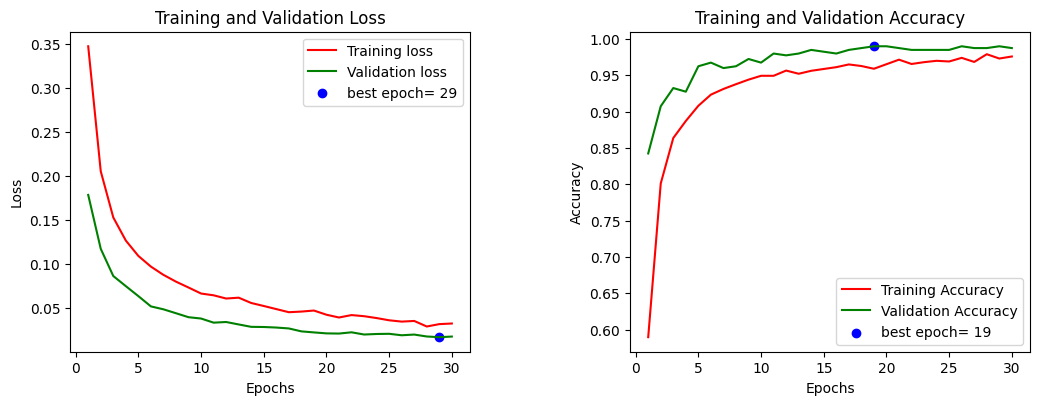

Wall time: 1.36 s


In [41]:
%%time
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (12, 4))
#plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest,  c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.subplot_tool()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
#plt.tight_layout(pad=20.0)
plt.show()